## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp006'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-5 / warmup_factor #1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

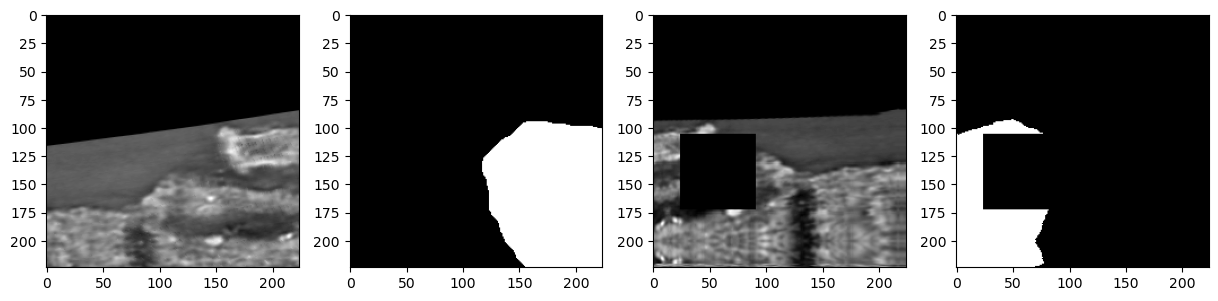

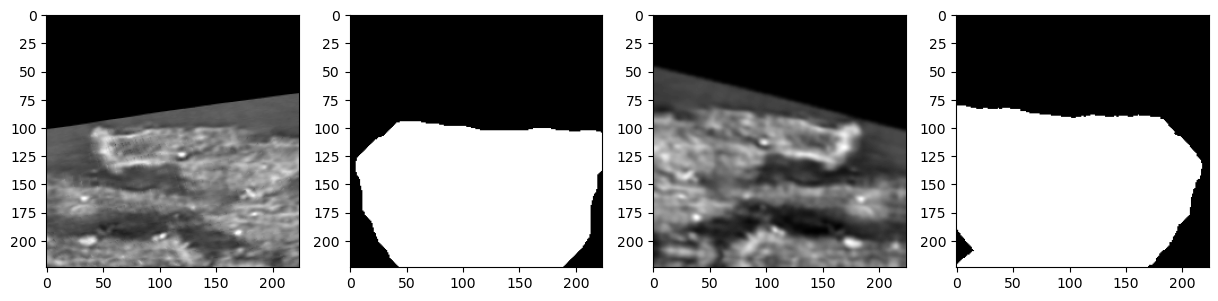

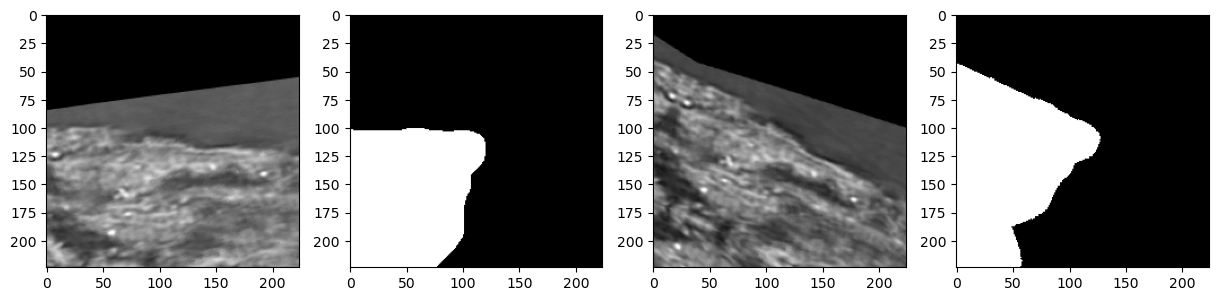

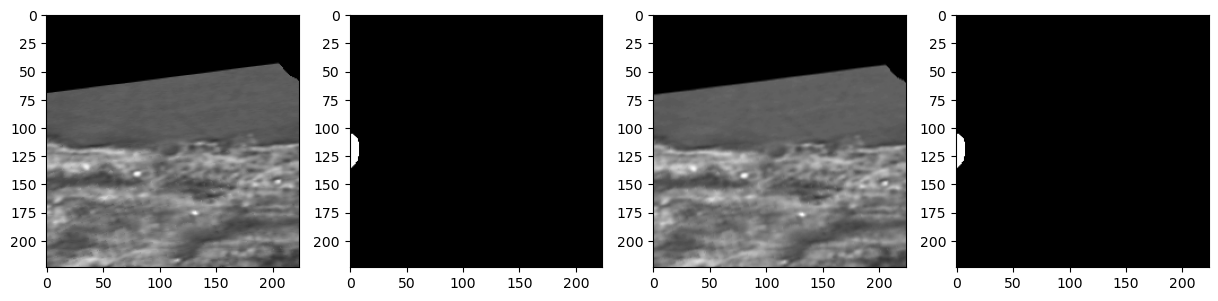

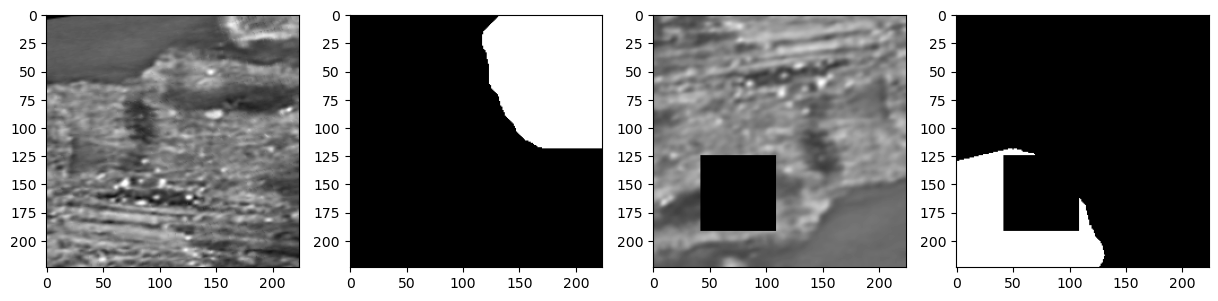

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48130

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09819916546825584
th: 0.15, fbeta: 0.13566228878657147
th: 0.2, fbeta: 0.1471613033701816
th: 0.25, fbeta: 0.1530342863663206
th: 0.3, fbeta: 0.1555389629451536
th: 0.35, fbeta: 0.1573350809124072
th: 0.4, fbeta: 0.15804207200546064
th: 0.45, fbeta: 0.155884465992491


best_th: 0.4, fbeta: 0.15804207200546064
Epoch 1 - avg_train_loss: 0.5273  avg_val_loss: 0.4264  time: 234s
Epoch 1 - avgScore: 0.1580
Epoch 1 - Save Best Score: 0.1580 Model
Epoch 1 - Save Best Loss: 0.4264 Model


th: 0.5, fbeta: 0.14756923750552284


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.0959969686810623
th: 0.15, fbeta: 0.13595237308432326
th: 0.2, fbeta: 0.15199356404601483
th: 0.25, fbeta: 0.15982698460491654
th: 0.3, fbeta: 0.1649758168633111
th: 0.35, fbeta: 0.17020318134871829
th: 0.4, fbeta: 0.17450784680578496
th: 0.45, fbeta: 0.17525949995059803


best_th: 0.45, fbeta: 0.17525949995059803
Epoch 2 - avg_train_loss: 0.4530  avg_val_loss: 0.4156  time: 238s
Epoch 2 - avgScore: 0.1753
Epoch 2 - Save Best Score: 0.1753 Model
Epoch 2 - Save Best Loss: 0.4156 Model


th: 0.5, fbeta: 0.16693578259764327


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.14394339450838636
th: 0.15, fbeta: 0.17507204916891622
th: 0.2, fbeta: 0.20581084534353022
th: 0.25, fbeta: 0.24420491614651949
th: 0.3, fbeta: 0.2850519280522985
th: 0.35, fbeta: 0.32149288772434503
th: 0.4, fbeta: 0.3504383969649156
th: 0.45, fbeta: 0.37326797692633046


best_th: 0.5, fbeta: 0.38553947725656323
Epoch 3 - avg_train_loss: 0.3693  avg_val_loss: 0.3002  time: 235s
Epoch 3 - avgScore: 0.3855
Epoch 3 - Save Best Score: 0.3855 Model
Epoch 3 - Save Best Loss: 0.3002 Model


th: 0.5, fbeta: 0.38553947725656323


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.16460341188754624
th: 0.15, fbeta: 0.19982110173487314
th: 0.2, fbeta: 0.24865657521501788
th: 0.25, fbeta: 0.3003045849195793
th: 0.3, fbeta: 0.34974329153136957
th: 0.35, fbeta: 0.39208646721404466
th: 0.4, fbeta: 0.42585476489398283
th: 0.45, fbeta: 0.4485679596382111


best_th: 0.5, fbeta: 0.4574472825032332
Epoch 4 - avg_train_loss: 0.3044  avg_val_loss: 0.2556  time: 235s
Epoch 4 - avgScore: 0.4574
Epoch 4 - Save Best Score: 0.4574 Model
Epoch 4 - Save Best Loss: 0.2556 Model


th: 0.5, fbeta: 0.4574472825032332


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2039893437856336
th: 0.15, fbeta: 0.2732908365557322
th: 0.2, fbeta: 0.33538557715267414
th: 0.25, fbeta: 0.387514262548471
th: 0.3, fbeta: 0.4258491622320845
th: 0.35, fbeta: 0.4539391074030116
th: 0.4, fbeta: 0.4756299652985308
th: 0.45, fbeta: 0.4907534596637087


best_th: 0.5, fbeta: 0.4977462654153027
Epoch 5 - avg_train_loss: 0.2749  avg_val_loss: 0.2254  time: 239s
Epoch 5 - avgScore: 0.4977
Epoch 5 - Save Best Score: 0.4977 Model
Epoch 5 - Save Best Loss: 0.2254 Model


th: 0.5, fbeta: 0.4977462654153027


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22113079997836532
th: 0.15, fbeta: 0.27663470829374814
th: 0.2, fbeta: 0.3263299129155739
th: 0.25, fbeta: 0.3708104794977837
th: 0.3, fbeta: 0.41007647296783456
th: 0.35, fbeta: 0.442119905810987
th: 0.4, fbeta: 0.46943464280709907
th: 0.45, fbeta: 0.49426290473838097


best_th: 0.5, fbeta: 0.5115248843715776
Epoch 6 - avg_train_loss: 0.2576  avg_val_loss: 0.2208  time: 237s
Epoch 6 - avgScore: 0.5115
Epoch 6 - Save Best Score: 0.5115 Model
Epoch 6 - Save Best Loss: 0.2208 Model


th: 0.5, fbeta: 0.5115248843715776


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2518387968183983
th: 0.15, fbeta: 0.3131666875433541
th: 0.2, fbeta: 0.36680271410950027
th: 0.25, fbeta: 0.40986580158983493
th: 0.3, fbeta: 0.44336390160023686
th: 0.35, fbeta: 0.4676848276160479
th: 0.4, fbeta: 0.48515907212038545
th: 0.45, fbeta: 0.49870436007632074


best_th: 0.5, fbeta: 0.5082460050655178
Epoch 7 - avg_train_loss: 0.2461  avg_val_loss: 0.2101  time: 235s
Epoch 7 - avgScore: 0.5082


th: 0.5, fbeta: 0.5082460050655178


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2175422432662142
th: 0.15, fbeta: 0.2567407513104461
th: 0.2, fbeta: 0.2991327912875096
th: 0.25, fbeta: 0.33866020445616307
th: 0.3, fbeta: 0.37323718464003525
th: 0.35, fbeta: 0.40378613145879505
th: 0.4, fbeta: 0.4322693592809765
th: 0.45, fbeta: 0.463368678707327


best_th: 0.5, fbeta: 0.49286188013137266
Epoch 8 - avg_train_loss: 0.2376  avg_val_loss: 0.2281  time: 238s
Epoch 8 - avgScore: 0.4929


th: 0.5, fbeta: 0.49286188013137266


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2369925997171739
th: 0.15, fbeta: 0.2770530923308183
th: 0.2, fbeta: 0.3156674342845697
th: 0.25, fbeta: 0.3502226701289854
th: 0.3, fbeta: 0.3795141542559106
th: 0.35, fbeta: 0.4040217151202756
th: 0.4, fbeta: 0.4275231911979795
th: 0.45, fbeta: 0.4493295432902344


best_th: 0.5, fbeta: 0.47169066702839674
Epoch 9 - avg_train_loss: 0.2284  avg_val_loss: 0.2279  time: 236s
Epoch 9 - avgScore: 0.4717


th: 0.5, fbeta: 0.47169066702839674


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2436506463898376
th: 0.15, fbeta: 0.28100533975626757
th: 0.2, fbeta: 0.3144554859093207
th: 0.25, fbeta: 0.3463171155759613
th: 0.3, fbeta: 0.3758097998096682
th: 0.35, fbeta: 0.4028143301978163
th: 0.4, fbeta: 0.4294072324808823
th: 0.45, fbeta: 0.4573316950921059


best_th: 0.5, fbeta: 0.4809358354162031
Epoch 10 - avg_train_loss: 0.2219  avg_val_loss: 0.2201  time: 236s
Epoch 10 - avgScore: 0.4809


th: 0.5, fbeta: 0.4809358354162031


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2264701957862729
th: 0.15, fbeta: 0.2552026131740362
th: 0.2, fbeta: 0.2816941786525146
th: 0.25, fbeta: 0.3055337643472177
th: 0.3, fbeta: 0.32838360175610426
th: 0.35, fbeta: 0.35192732400930654
th: 0.4, fbeta: 0.37388465442309016
th: 0.45, fbeta: 0.3961646333753978


best_th: 0.5, fbeta: 0.42117693702759856
Epoch 11 - avg_train_loss: 0.2155  avg_val_loss: 0.2517  time: 238s
Epoch 11 - avgScore: 0.4212


th: 0.5, fbeta: 0.42117693702759856


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2111102740167289
th: 0.15, fbeta: 0.2362241055342524
th: 0.2, fbeta: 0.26174215457810124
th: 0.25, fbeta: 0.28868747384521526
th: 0.3, fbeta: 0.3143377634896277
th: 0.35, fbeta: 0.3400420745155374
th: 0.4, fbeta: 0.3659444158231981
th: 0.45, fbeta: 0.3930479641215906


best_th: 0.5, fbeta: 0.417989464818828
Epoch 12 - avg_train_loss: 0.2092  avg_val_loss: 0.2560  time: 236s
Epoch 12 - avgScore: 0.4180


th: 0.5, fbeta: 0.417989464818828


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22129281179869928
th: 0.15, fbeta: 0.2512753091163081
th: 0.2, fbeta: 0.27936876497944413
th: 0.25, fbeta: 0.3069678086016533
th: 0.3, fbeta: 0.33268095294963956
th: 0.35, fbeta: 0.35615922150662305
th: 0.4, fbeta: 0.3807774971390703
th: 0.45, fbeta: 0.40479074275079147


best_th: 0.5, fbeta: 0.42894131766165283
Epoch 13 - avg_train_loss: 0.2034  avg_val_loss: 0.2496  time: 237s
Epoch 13 - avgScore: 0.4289


th: 0.5, fbeta: 0.42894131766165283


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21425727975597317
th: 0.15, fbeta: 0.24000945240605492
th: 0.2, fbeta: 0.2654975790362651
th: 0.25, fbeta: 0.29026728979557725
th: 0.3, fbeta: 0.31582711852634804
th: 0.35, fbeta: 0.34106176314503106
th: 0.4, fbeta: 0.36690343908523126
th: 0.45, fbeta: 0.3902356316087546


best_th: 0.5, fbeta: 0.4137892701894781
Epoch 14 - avg_train_loss: 0.1976  avg_val_loss: 0.2586  time: 238s
Epoch 14 - avgScore: 0.4138


th: 0.5, fbeta: 0.4137892701894781


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.21607344132502534
th: 0.15, fbeta: 0.23929843389200062
th: 0.2, fbeta: 0.26223627327290666
th: 0.25, fbeta: 0.28558860167907735
th: 0.3, fbeta: 0.3064099296546308
th: 0.35, fbeta: 0.3257987345262877
th: 0.4, fbeta: 0.3469501278596564
th: 0.45, fbeta: 0.3693560699570344


best_th: 0.5, fbeta: 0.39233948156662396
Epoch 15 - avg_train_loss: 0.1957  avg_val_loss: 0.2774  time: 235s
Epoch 15 - avgScore: 0.3923


th: 0.5, fbeta: 0.39233948156662396


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22184500701448467
th: 0.15, fbeta: 0.25043770371459984
th: 0.2, fbeta: 0.27673322509476983
th: 0.25, fbeta: 0.30382426813473024
th: 0.3, fbeta: 0.3298244108959191
th: 0.35, fbeta: 0.35348463308238487
th: 0.4, fbeta: 0.37823031672817503
th: 0.45, fbeta: 0.4058300617106849


best_th: 0.5, fbeta: 0.43505646279840315
Epoch 16 - avg_train_loss: 0.1886  avg_val_loss: 0.2494  time: 238s
Epoch 16 - avgScore: 0.4351


th: 0.5, fbeta: 0.43505646279840315


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23532266201399984
th: 0.15, fbeta: 0.26877757307306227
th: 0.2, fbeta: 0.29938269395015704
th: 0.25, fbeta: 0.3287882667067301
th: 0.3, fbeta: 0.3547459164702136
th: 0.35, fbeta: 0.3804983705654666
th: 0.4, fbeta: 0.4062150355038269
th: 0.45, fbeta: 0.43230074700569093


best_th: 0.5, fbeta: 0.45495101745040734
Epoch 17 - avg_train_loss: 0.1850  avg_val_loss: 0.2396  time: 238s
Epoch 17 - avgScore: 0.4550


th: 0.5, fbeta: 0.45495101745040734


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2499695885982054
th: 0.15, fbeta: 0.284188100007365
th: 0.2, fbeta: 0.3146909355272825
th: 0.25, fbeta: 0.34203633915856463
th: 0.3, fbeta: 0.3672386935872746
th: 0.35, fbeta: 0.3911001925733195
th: 0.4, fbeta: 0.4148897090517178
th: 0.45, fbeta: 0.4355788271897073


best_th: 0.5, fbeta: 0.45413798063261945
Epoch 18 - avg_train_loss: 0.1819  avg_val_loss: 0.2400  time: 235s
Epoch 18 - avgScore: 0.4541


th: 0.5, fbeta: 0.45413798063261945


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2487425460830111
th: 0.15, fbeta: 0.28164891696390537
th: 0.2, fbeta: 0.31036959600958225
th: 0.25, fbeta: 0.33709654918277526
th: 0.3, fbeta: 0.3625991902469475
th: 0.35, fbeta: 0.38781638172604316
th: 0.4, fbeta: 0.41282454646062694
th: 0.45, fbeta: 0.43446478513599657


best_th: 0.5, fbeta: 0.4529749697679077
Epoch 19 - avg_train_loss: 0.1782  avg_val_loss: 0.2398  time: 237s
Epoch 19 - avgScore: 0.4530


th: 0.5, fbeta: 0.4529749697679077


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.250005426045223
th: 0.15, fbeta: 0.28714949071892254
th: 0.2, fbeta: 0.3180669126880042
th: 0.25, fbeta: 0.34678838344910456
th: 0.3, fbeta: 0.3721727588271698
th: 0.35, fbeta: 0.39456682771957624
th: 0.4, fbeta: 0.41403915160570715
th: 0.45, fbeta: 0.43284656843001845


best_th: 0.5, fbeta: 0.4469840521872619
Epoch 20 - avg_train_loss: 0.1721  avg_val_loss: 0.2388  time: 238s
Epoch 20 - avgScore: 0.4470


th: 0.5, fbeta: 0.4469840521872619


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2357613704715393
th: 0.15, fbeta: 0.2641864581712915
th: 0.2, fbeta: 0.28912935020966724
th: 0.25, fbeta: 0.314730295835714
th: 0.3, fbeta: 0.34180950138639776
th: 0.35, fbeta: 0.36725570496133475
th: 0.4, fbeta: 0.3917228515836349
th: 0.45, fbeta: 0.41396622209676737


best_th: 0.5, fbeta: 0.43544085258183846
Epoch 21 - avg_train_loss: 0.1714  avg_val_loss: 0.2583  time: 235s
Epoch 21 - avgScore: 0.4354


th: 0.5, fbeta: 0.43544085258183846


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2551990327953127
th: 0.15, fbeta: 0.289528758595431
th: 0.2, fbeta: 0.3212028104484603
th: 0.25, fbeta: 0.3487427122115017
th: 0.3, fbeta: 0.3730355639119039
th: 0.35, fbeta: 0.3968025115898855
th: 0.4, fbeta: 0.42225355054574754


best_th: 0.5, fbeta: 0.46631962847333275
Epoch 22 - avg_train_loss: 0.1687  avg_val_loss: 0.2411  time: 237s
Epoch 22 - avgScore: 0.4663


th: 0.45, fbeta: 0.4459177196340013
th: 0.5, fbeta: 0.46631962847333275


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2733521209254095
th: 0.15, fbeta: 0.3128256297640013
th: 0.2, fbeta: 0.34546450228876924
th: 0.25, fbeta: 0.3733889782618037
th: 0.3, fbeta: 0.3989528816419173
th: 0.35, fbeta: 0.42455763386480544
th: 0.4, fbeta: 0.44854381642709373
th: 0.45, fbeta: 0.46903351719037123


best_th: 0.5, fbeta: 0.4861613453706262
Epoch 23 - avg_train_loss: 0.1658  avg_val_loss: 0.2283  time: 238s
Epoch 23 - avgScore: 0.4862


th: 0.5, fbeta: 0.4861613453706262


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2320486108173333
th: 0.15, fbeta: 0.2607021327164751
th: 0.2, fbeta: 0.28805582913180844
th: 0.25, fbeta: 0.3129970391751779
th: 0.3, fbeta: 0.33730927104023944
th: 0.35, fbeta: 0.36023374855597246
th: 0.4, fbeta: 0.38184475032282134
th: 0.45, fbeta: 0.40347241931550276


best_th: 0.5, fbeta: 0.42612377889068187
Epoch 24 - avg_train_loss: 0.1637  avg_val_loss: 0.2665  time: 236s
Epoch 24 - avgScore: 0.4261


th: 0.5, fbeta: 0.42612377889068187


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25411265411016254
th: 0.15, fbeta: 0.29105965909370335
th: 0.2, fbeta: 0.3256510979230234
th: 0.25, fbeta: 0.35619118002263844
th: 0.3, fbeta: 0.3843701677623949
th: 0.35, fbeta: 0.4091219099030945
th: 0.4, fbeta: 0.4305782129633697
th: 0.45, fbeta: 0.4504888085073609


best_th: 0.5, fbeta: 0.4685774499642486
Epoch 25 - avg_train_loss: 0.1616  avg_val_loss: 0.2335  time: 237s
Epoch 25 - avgScore: 0.4686


th: 0.5, fbeta: 0.4685774499642486


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2598614508449712
th: 0.15, fbeta: 0.29900626714266987
th: 0.2, fbeta: 0.3336126225571727
th: 0.25, fbeta: 0.3633803415835457
th: 0.3, fbeta: 0.391564238458098
th: 0.35, fbeta: 0.4178169021177187
th: 0.4, fbeta: 0.439911747890732
th: 0.45, fbeta: 0.45937168051856453


best_th: 0.5, fbeta: 0.47618163099907945
Epoch 26 - avg_train_loss: 0.1603  avg_val_loss: 0.2332  time: 238s
Epoch 26 - avgScore: 0.4762


th: 0.5, fbeta: 0.47618163099907945


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2547966289547196
th: 0.15, fbeta: 0.2886702687566276
th: 0.2, fbeta: 0.3205282437530924
th: 0.25, fbeta: 0.34852485327254284
th: 0.3, fbeta: 0.3732977730757105
th: 0.35, fbeta: 0.3974502587554268
th: 0.4, fbeta: 0.4190733670527588


best_th: 0.5, fbeta: 0.45697792734106274
Epoch 27 - avg_train_loss: 0.1601  avg_val_loss: 0.2445  time: 236s
Epoch 27 - avgScore: 0.4570


th: 0.45, fbeta: 0.43843310678844616
th: 0.5, fbeta: 0.45697792734106274


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24630883946951193
th: 0.15, fbeta: 0.27619104818849605
th: 0.2, fbeta: 0.30629499563496826
th: 0.25, fbeta: 0.3333029235312654
th: 0.3, fbeta: 0.3587432812054948
th: 0.35, fbeta: 0.3827330539181447
th: 0.4, fbeta: 0.4047309832844703
th: 0.45, fbeta: 0.42516886374216933


best_th: 0.5, fbeta: 0.4453822652801531
Epoch 28 - avg_train_loss: 0.1590  avg_val_loss: 0.2570  time: 237s
Epoch 28 - avgScore: 0.4454


th: 0.5, fbeta: 0.4453822652801531


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24301009336210144
th: 0.15, fbeta: 0.27112506585069535
th: 0.2, fbeta: 0.2992854461675416
th: 0.25, fbeta: 0.32675161421173876
th: 0.3, fbeta: 0.3520626230478028
th: 0.35, fbeta: 0.37697347646142654
th: 0.4, fbeta: 0.3997122516475534
th: 0.45, fbeta: 0.42025053952496905


best_th: 0.5, fbeta: 0.44092287253963436
Epoch 29 - avg_train_loss: 0.1571  avg_val_loss: 0.2587  time: 237s
Epoch 29 - avgScore: 0.4409


th: 0.5, fbeta: 0.44092287253963436


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2397077363160144
th: 0.15, fbeta: 0.2684917693261817
th: 0.2, fbeta: 0.2970850409693625
th: 0.25, fbeta: 0.3243022663776048
th: 0.3, fbeta: 0.3490388143989927
th: 0.35, fbeta: 0.37237439853555826
th: 0.4, fbeta: 0.3953823582956532
th: 0.45, fbeta: 0.4174072279259843


best_th: 0.5, fbeta: 0.43792770752059684
Epoch 30 - avg_train_loss: 0.1568  avg_val_loss: 0.2575  time: 235s
Epoch 30 - avgScore: 0.4379


th: 0.5, fbeta: 0.43792770752059684


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.22113079997836532
th: 0.15, fbeta: 0.27663470829374814
th: 0.2, fbeta: 0.3263299129155739
th: 0.25, fbeta: 0.3708104794977837
th: 0.3, fbeta: 0.41007647296783456
th: 0.35, fbeta: 0.442119905810987
th: 0.4, fbeta: 0.46943464280709907


best_th: 0.5, fbeta: 0.5115248843715776


th: 0.45, fbeta: 0.49426290473838097
th: 0.5, fbeta: 0.5115248843715776


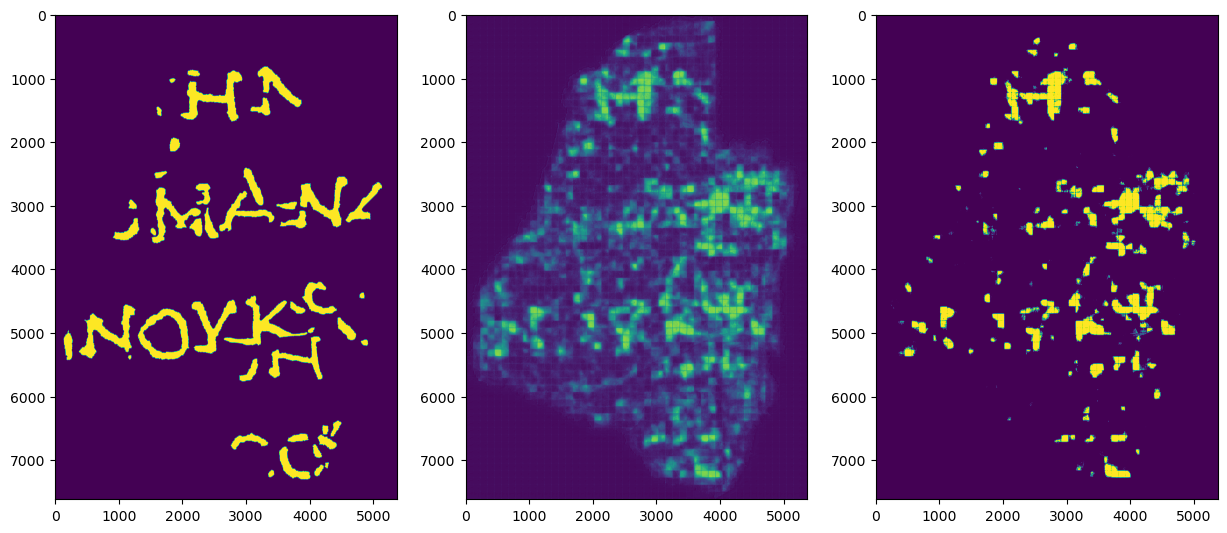

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.6477116e+07, 7.2244160e+06, 4.8564790e+06, 2.9051130e+06,
        1.9936430e+06, 1.4111710e+06, 1.0542620e+06, 8.2827500e+05,
        6.6803400e+05, 5.9271000e+05, 5.3439600e+05, 4.8023600e+05,
        4.3985900e+05, 3.9609500e+05, 3.6564900e+05, 4.3199200e+05,
        2.6703700e+05, 1.6789000e+04, 3.2600000e+02, 1.8000000e+01]),
 array([1.72746448e-04, 4.42775946e-02, 8.83824428e-02, 1.32487291e-01,
        1.76592139e-01, 2.20696987e-01, 2.64801836e-01, 3.08906684e-01,
        3.53011532e-01, 3.97116380e-01, 4.41221228e-01, 4.85326077e-01,
        5.29430925e-01, 5.73535773e-01, 6.17640621e-01, 6.61745469e-01,
        7.05850318e-01, 7.49955166e-01, 7.94060014e-01, 8.38164862e-01,
        8.82269710e-01]),
 <BarContainer object of 20 artists>)

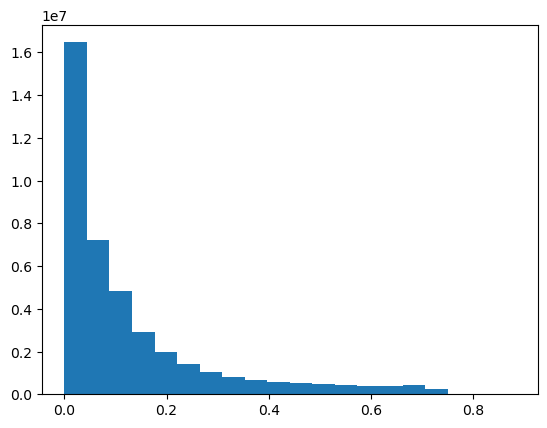

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000